# Experimentación - AGREGANDO DATA EXTERNA

## Modelo - Ubicación (Latitud y Longitud, Continente)

### Voy a experimentar con las caracterisiticas principales de los países, como su ubicación, su status, su capacidad de gasto. Todo ese tipo de atributos que lo encasillan en una etiqueta en particular. La zona donde se ubica un país puede explicar varias cosas sobre él. Si pensamos en un país ubicado en el hemisferio norte del planeta, es probable que demos con uno desarrollado. Mientras que si, por ejemplo, pensamos en un pais ubicado en África, es probable que su expectativa de vida sea menor a la media. Vamos a ver como esto se condice con los datos y el análisis de regresión.

### Importo todos los módulos, funciones y datasets que me son de ayuda para la experimentación.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence as influence

def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage


df_exp = pd.read_csv("expectativa_de_vida.csv")
df_coord = pd.read_csv("average-latitude-longitude-countries.csv")

### Armo el data set con la ubicación en el mapa de cada país (como se realiza en el archivo 'Mapa.ipynb').

In [2]:
paises = []
nombres1 = df_exp["Country"].tolist()
nombres2 = df_coord["Country"].tolist()

from difflib import SequenceMatcher

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [3]:
df = df_exp
latitudes = []
longitudes = []

for i in range(len(paises)):
    lat = df_coord[df_coord["Country"]==paises[i][1]]["Latitude"].values
    long = df_coord[df_coord["Country"]==paises[i][1]]["Longitude"].values
    if len(lat) > 0:
        lat = lat[0]
        long = long[0]
    else:
        lat = 0
        long = 0
    latitudes.append(lat)
    longitudes.append(long)

df["Latitude"] = latitudes
df["Longitude"] = longitudes

In [4]:
df['Status_Float'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       183 non-null    int64  
 1   Country                          183 non-null    object 
 2   Life expectancy                  183 non-null    float64
 3   Adult Mortality                  183 non-null    float64
 4   infant deaths                    183 non-null    float64
 5   Alcohol                          182 non-null    float64
 6   percentage expenditure           183 non-null    float64
 7   Hepatitis B                      174 non-null    float64
 8   Measles                          183 non-null    float64
 9   BMI                              181 non-null    float64
 10  under-five deaths                183 non-null    float64
 11  Polio                            183 non-null    float64
 12  Total expenditure     

### Ahora agrego la zona donde se encuentra cada Estado.

In [6]:
df_zona = pd.read_csv("country-and-continent-codes-list.csv")

In [7]:
df_zona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Continent_Name             262 non-null    object 
 1   Continent_Code             219 non-null    object 
 2   Country_Name               262 non-null    object 
 3   Two_Letter_Country_Code    261 non-null    object 
 4   Three_Letter_Country_Code  258 non-null    object 
 5   Country_Number             258 non-null    float64
dtypes: float64(1), object(5)
memory usage: 12.4+ KB


### Equivalencia entre paises

In [8]:
paises = []
nombres1 = df["Country"].tolist()
nombres2 = df_zona["Country_Name"].tolist()

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        
        """
        if ((match[2] == len(n1)) or (match[2] == len(n2))):
            r = seq.ratio()
            conSubstringsEnComun.append([r,n1,n2])
        """
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [9]:
df_new = df
zonas = []

for i in range(len(paises)):
    zone = df_zona[df_zona["Country_Name"]==paises[i][1]]["Continent_Name"].values
    if len(zone) > 0:
        zone = zone[0]
    else:
        zone = 'null'
    zonas.append(zone)

df_new["Continente"] = zonas

In [10]:
df_new["Continente"]

0               Asia
1             Europe
2             Africa
3               Asia
4      North America
           ...      
178    South America
179             null
180             Asia
181           Africa
182           Africa
Name: Continente, Length: 183, dtype: object

### Veo aquellos paises que quedaron sin zona y los completamos.

In [11]:
df_new[df_new["Continente"] == 'null']

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Latitude,Longitude,Status_Float,Continente
19,19,Bolivia (Plurinational State of),67.70625,177.5000,10.7500,3.212000,0.000000,82.875000,7.6250,44.81875,...,NaN,1.30000,1.1875,0.633750,13.9625,Developing,-17.0,-65.0,0,null
27,27,Cabo Verde,72.51875,116.1875,0.0000,3.448000,188.632987,80.642857,0.1250,24.37500,...,292600.25,8.01250,7.9750,0.570000,12.2000,Developing,16.0,-24.0,0,null
42,43,Czechia,76.76875,71.8125,0.0000,13.026000,0.000000,97.285714,22.9375,55.71250,...,NaN,1.99375,2.0625,NaN,NaN,Developed,0.0,0.0,1,null
88,90,Kyrgyzstan,69.08125,173.6875,3.7500,2.267333,0.000000,85.562500,1156.6250,35.11250,...,NaN,3.35625,3.4125,0.622063,12.3375,Developing,41.0,75.0,0,null
179,189,Viet Nam,74.77500,126.5625,29.1875,3.087333,0.000000,87.538462,4232.9375,11.18750,...,NaN,14.92500,15.6250,0.627063,11.5125,Developing,16.0,106.0,0,null


### Les asigno sus respectivos continentes.

In [12]:
df_new.loc[19, 'Continente'] = 'South America' #Bolivia
df_new.loc[27, 'Continente'] = 'Africa' #Cabo Verde
df_new.loc[42, 'Continente'] = 'Europe' #Czechia
df_new.loc[88, 'Continente'] = 'Asia' # Kyrgyzstan
df_new.loc[179, 'Continente'] = 'Asia' #Viet Nam

In [13]:
df_new[df_new['Country'] == 'Bolivia (Plurinational State of)']['Continente'] 

19    South America
Name: Continente, dtype: object

### Vemos como se compara la expectativa de vida en cada región siendo un país desarrollado o sub-desarrollado.

<AxesSubplot:xlabel='Continente', ylabel='Life expectancy'>

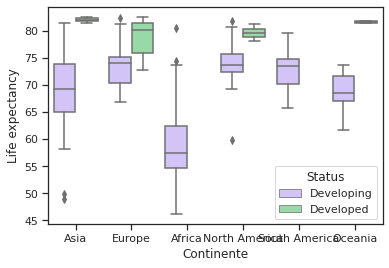

In [14]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Continente", y="Life expectancy",
            hue="Status", palette=["m", "g"],
            data=df_new)

### Le agrego valor numérico a los continentes.

In [15]:
continentes = []
countries = df['Country']

for i in range(len(countries)):
    cont = df_new[df_new["Country"] == countries[i]]["Continente"].values
    if len(cont) > 0:
        cont = cont[0]
        if cont == 'Africa':
            cont = 0
        elif cont == 'Asia': 
            cont = 1 
        elif cont == 'South America':
            cont = 2 
        elif cont == 'North America': 
            cont = 3 
        elif cont == 'Oceania':
            cont = 4 
        elif cont == 'Europe':
            cont = 5
        
    else:
        cont = -1
    continentes.append(cont)

df_new["Continente_Nro"] = continentes

In [16]:
df_new.corr()['Continente_Nro']

Unnamed: 0                        -0.033727
Life expectancy                    0.652746
Adult Mortality                   -0.550071
infant deaths                     -0.186443
Alcohol                            0.640571
percentage expenditure             0.429690
Hepatitis B                        0.184245
Measles                           -0.204647
BMI                                0.731121
under-five deaths                 -0.198875
Polio                              0.410837
Total expenditure                  0.422968
Diphtheria                         0.406470
HIV/AIDS                          -0.364967
GDP                                0.428181
Population                        -0.077632
thinness  1-19 years              -0.615603
thinness 5-9 years                -0.606105
Income composition of resources    0.584496
Schooling                          0.628131
Latitude                           0.502346
Longitude                         -0.127667
Status_Float                    

### Notamos una aceptable correlación entre la zona de un país y su expectativa de vida. Así también como entre la zona y el status de un país.

In [17]:
df_new.corr()['Life expectancy']

Unnamed: 0                        -0.017423
Life expectancy                    1.000000
Adult Mortality                   -0.896441
infant deaths                     -0.199914
Alcohol                            0.461720
percentage expenditure             0.524320
Hepatitis B                        0.429536
Measles                           -0.201076
BMI                                0.723824
under-five deaths                 -0.225785
Polio                              0.679231
Total expenditure                  0.290713
Diphtheria                         0.672322
HIV/AIDS                          -0.587153
GDP                                0.611808
Population                        -0.039915
thinness  1-19 years              -0.523989
thinness 5-9 years                -0.515970
Income composition of resources    0.817545
Schooling                          0.794457
Latitude                           0.471175
Longitude                         -0.098699
Status_Float                    

### Sabiendo las coordenadas de cada país, analizamos como estas infieren en su expectativa de vida.

VIF for Latitude 1.0437650861009335
VIF for Longitude 1.0437650861009335
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     27.76
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           3.12e-11
Time:                        23:17:33   Log-Likelihood:                -640.41
No. Observations:                 183   AIC:                             1287.
Df Residuals:                     180   BIC:                             1296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

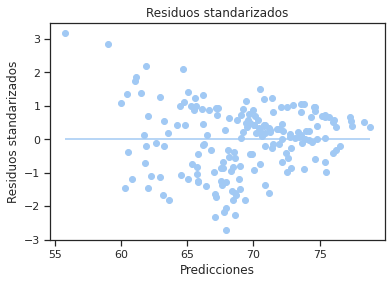

<Figure size 2160x2160 with 0 Axes>

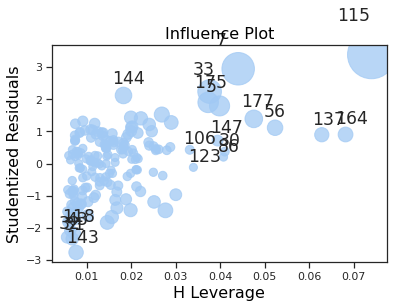

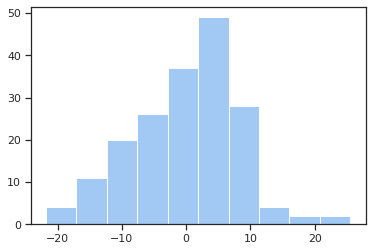

{'r2': 0.235703390469284,
 'rmse': 8.009178403974595,
 'adjusted': 0.22721120591894284}

In [18]:
run_analysis(['Latitude', 'Longitude'], df_new)

### Por lo pronto no hay un valor considerable en el ajuste. ¿Y si añadimos su zona? ¿Nos proveerá más información esto?

### Agregamos el continente de un país.

VIF for Latitude 2.1184585408091157
VIF for Longitude 1.0444746737724804
VIF for Continente_Nro 2.0640936873190463
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     49.77
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           1.92e-23
Time:                        23:30:40   Log-Likelihood:                -609.50
No. Observations:                 183   AIC:                             1227.
Df Residuals:                     179   BIC:                             1240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

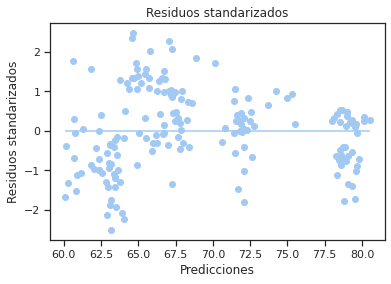

<Figure size 2160x2160 with 0 Axes>

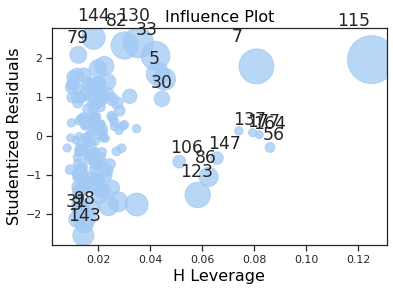

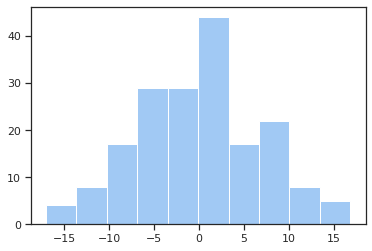

{'r2': 0.4548010673472779,
 'rmse': 6.7644812855221925,
 'adjusted': 0.44566365506818195}

In [64]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro'], df_new)

### Ahora sí, mejora considerablemente. ¿Qué pasa si agregamos el status de un país también?

VIF for Latitude 2.16443249226915
VIF for Longitude 1.0477957952165617
VIF for Status_Float 1.861771910735161
VIF for Continente_Nro 2.628976355914444
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     39.38
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           1.35e-23
Time:                        23:17:47   Log-Likelihood:                -607.01
No. Observations:                 183   AIC:                             1224.
Df Residuals:                     178   BIC:                             1240.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

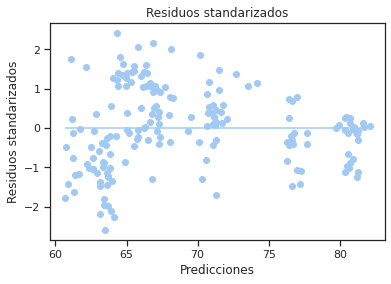

<Figure size 2160x2160 with 0 Axes>

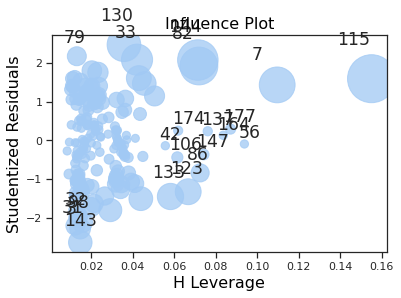

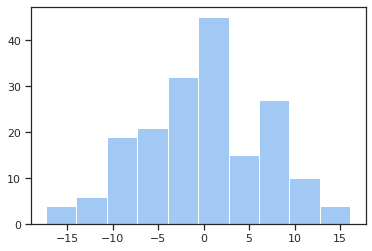

{'r2': 0.4694893925077669,
 'rmse': 6.672737449810843,
 'adjusted': 0.4575678058225482}

In [20]:
run_analysis(['Latitude', 'Longitude', 'Status_Float', 'Continente_Nro'], df_new)

### No mejora casi nada, podría descartarlo. Finalizemos agregando el gasto por país, esto seguro nos dará un mayor contexto. Mezclando no solo la geografía de los países sino también las finanzas, estos atributos van de la mano con el 'Status' de un país. ¿Estarán tan correlacionados con la zona como este último?

In [57]:
df_new[f'Normalizado_Gasto'] = (df_new['percentage expenditure']-np.mean(df_new['percentage expenditure']))/np.std(df_new['percentage expenditure'])

VIF for Latitude 2.1495789763968847
VIF for Longitude 1.049219451642314
VIF for Continente_Nro 2.0998009253487933
VIF for Normalizado_Gasto 1.1110861272424153
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     47.26
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           4.98e-27
Time:                        23:32:19   Log-Likelihood:                -598.79
No. Observations:                 183   AIC:                             1208.
Df Residuals:                     178   BIC:                             1224.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

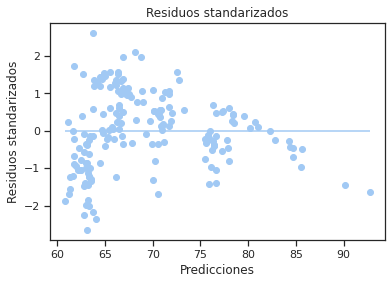

<Figure size 2160x2160 with 0 Axes>

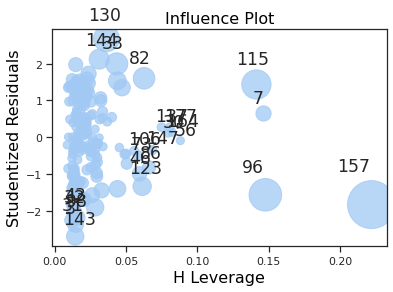

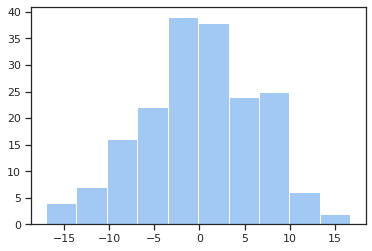

{'r2': 0.5150521255525957,
 'rmse': 6.379762789467062,
 'adjusted': 0.5041544205088337}

In [66]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro', 'Normalizado_Gasto'], df_new)

### Subió el ajuste, pero no tanto. ¿Será porque la zona de un país y su gasto están demasiado correlacionados?

In [71]:
df_new.corr()['Continente_Nro']

Unnamed: 0                        -0.033727
Life expectancy                    0.652746
Adult Mortality                   -0.550071
infant deaths                     -0.186443
Alcohol                            0.640571
percentage expenditure             0.429690
Hepatitis B                        0.184245
Measles                           -0.204647
BMI                                0.731121
under-five deaths                 -0.198875
Polio                              0.410837
Total expenditure                  0.422968
Diphtheria                         0.406470
HIV/AIDS                          -0.364967
GDP                                0.428181
Population                        -0.077632
thinness  1-19 years              -0.615603
thinness 5-9 years                -0.606105
Income composition of resources    0.584496
Schooling                          0.628131
Latitude                           0.502346
Longitude                         -0.127667
Status_Float                    

### No tanto como el tipo de continente y el status de un país

## Saco outliers

### Residuos

VIF for Latitude 2.1495789763968847
VIF for Longitude 1.049219451642314
VIF for Continente_Nro 2.0998009253487933
VIF for Normalizado_Gasto 1.1110861272424153


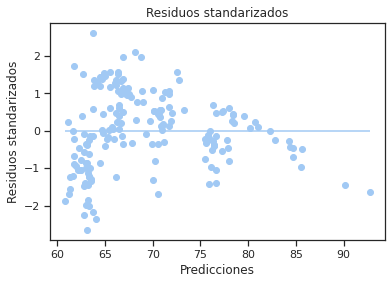

In [72]:
residuos_out = residuos(['Latitude', 'Longitude', 'Continente_Nro', 'Normalizado_Gasto'], df_new)

In [73]:
df_new_out = df_new.assign(residuos_out = residuos_out)

In [74]:
df_new_out = df_new_out[(df_new_out["residuos_out"]**2)**0.5 <= 2]

### Distancia de Cook

In [81]:
cook_out, p_out = cooksDist(['Latitude', 'Longitude', 'Continente_Nro', 'Normalizado_Gasto'], df_new_out)

VIF for Latitude 2.163534985988965
VIF for Longitude 1.0462431726428032
VIF for Continente_Nro 2.103798076783631
VIF for Normalizado_Gasto 1.0953785812916694


In [82]:
df_new_out = df_new_out.assign(cook_out = cook_out)

In [83]:
df_new_out = df_new_out[df_new_out["cook_out"] < 0.1]

### Leverage

In [84]:
leverage_out = getLeverage(['Latitude', 'Longitude', 'Continente_Nro', 'Normalizado_Gasto'], df_new_out)

VIF for Latitude 2.1304218197287637
VIF for Longitude 1.0463551927324453
VIF for Continente_Nro 2.0685031137365497
VIF for Normalizado_Gasto 1.0750346309706458


In [85]:
df_new_out = df_new_out.assign(leverage_out = leverage_out)

In [86]:
df_new_out = df_new_out[df_new_out["leverage_out"] < 0.06]

### Rehago análisis

VIF for Latitude 3.20741760603523
VIF for Longitude 1.2909303262652916
VIF for Continente_Nro 2.8870954386434247
VIF for Normalizado_Gasto 1.029982180387026
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     45.21
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           5.70e-25
Time:                        23:41:14   Log-Likelihood:                -494.98
No. Observations:                 157   AIC:                             1000.
Df Residuals:                     152   BIC:                             1015.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

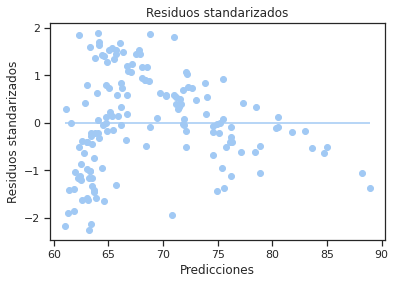

<Figure size 2160x2160 with 0 Axes>

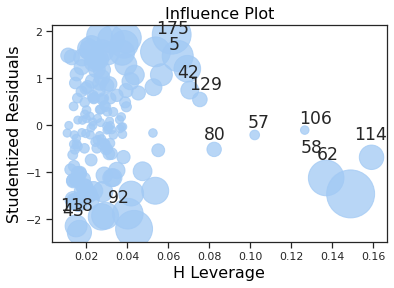

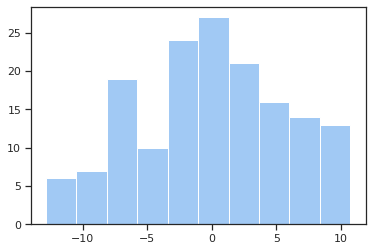

{'r2': 0.5433346087760376,
 'rmse': 5.662027382965417,
 'adjusted': 0.5313170984806701}

In [87]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro', 'Normalizado_Gasto'], df_new_out)

### Dio muchos mejores valores

### ¿Cómo se comportan los países de status 'Developing'?

## Modelo - Developing

In [23]:
df_developing = df_new[df_new['Status'] == 'Developing']

<AxesSubplot:xlabel='Continente', ylabel='Life expectancy'>

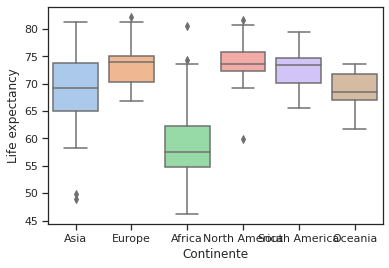

In [24]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Continente", y="Life expectancy", data=df_developing)

VIF for Latitude 1.6469374325109627
VIF for Longitude 1.0896403361397353
VIF for Continente_Nro 1.5366483269123348
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     28.19
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           1.85e-14
Time:                        23:18:04   Log-Likelihood:                -504.94
No. Observations:                 151   AIC:                             1018.
Df Residuals:                     147   BIC:                             1030.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

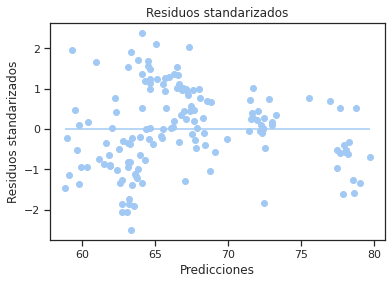

<Figure size 2160x2160 with 0 Axes>

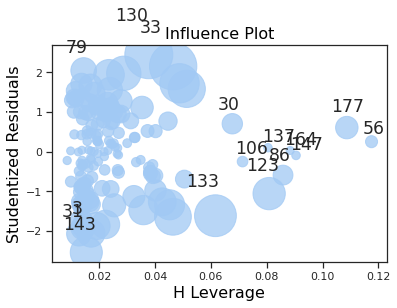

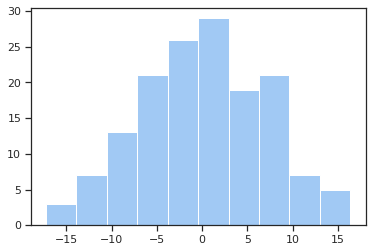

{'r2': 0.3652173990021643,
 'rmse': 6.855555902913486,
 'adjusted': 0.35226265204302476}

In [25]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro'], df_developing)

## Sacando data dudosa

### Si recordamos el análisis de datos hecho en el archivo 'EDA.ipynb', vemos que habían varios países categorizados de manera sospechosa. Veamos el caso de los países con status 'Developing'

In [26]:
df[(df["Life expectancy"] > 80) & (df["Status"] == "Developing")]

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,thinness 5-9 years,Income composition of resources,Schooling,Status,Latitude,Longitude,Status_Float,Continente,Continente_Nro,Normalizado_Gasto
30,30,Canada,81.68750,64.6250,2.0000,8.053333,4694.078971,28.846154,129.5000,55.86250,...,0.43750,0.892188,15.87500,Developing,60.0,-95.00,0,North America,3,2.677105
57,59,Finland,80.71250,68.8750,0.0000,9.552667,2889.315470,NaN,2.8125,52.30000,...,0.80625,0.872937,17.29375,Developing,64.0,26.00,0,North America,3,1.455092
58,60,France,82.21875,73.1250,2.9375,12.404667,3751.506574,51.250000,2661.6250,51.98125,...,0.60000,0.870562,15.90000,Developing,46.0,2.00,0,Europe,5,2.038885
64,66,Greece,81.21875,73.6250,0.1875,8.803333,1759.246820,88.937500,24.8750,58.68125,...,0.73125,0.842313,15.93750,Developing,39.0,22.00,0,Europe,5,0.689919
79,81,Israel,81.30000,59.5000,0.9375,2.497333,1467.535827,97.437500,138.9375,54.98750,...,1.10000,0.873188,15.71250,Developing,31.5,34.75,0,Asia,1,0.492400
130,137,Republic of Korea,80.48750,76.1875,2.1250,8.855333,0.000000,95.125000,3548.4375,23.24375,...,1.01875,NaN,NaN,Developing,37.0,127.50,0,Africa,0,-0.501274


### Todos estos países tranquilamente podrían ser considerados como 'Developed'. Veamos que sucede en el análisis cuando se quita a estos países.

In [27]:
df_developing = df_developing[(df_developing["Life expectancy"] < 80)]

VIF for Latitude 1.5717488696271056
VIF for Longitude 1.0977977335577598
VIF for Continente_Nro 1.454289034394098
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     24.66
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           6.90e-13
Time:                        23:18:08   Log-Likelihood:                -481.56
No. Observations:                 145   AIC:                             971.1
Df Residuals:                     141   BIC:                             983.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

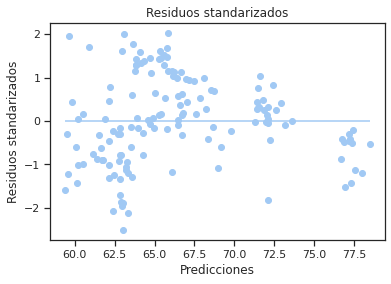

<Figure size 2160x2160 with 0 Axes>

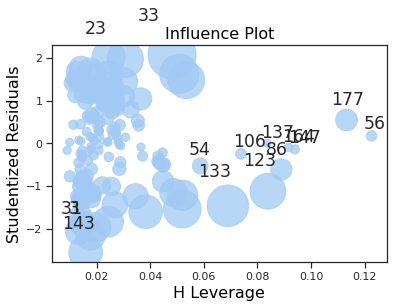

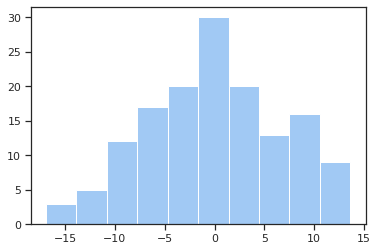

{'r2': 0.34412981676708165,
 'rmse': 6.700298358492688,
 'adjusted': 0.3301751320174451}

In [28]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro'], df_developing)

### El ajuste se reduce, no es tan eficiente

## Saco outliers

### Primero residuos

VIF for Latitude 1.5717488696271056
VIF for Longitude 1.0977977335577598
VIF for Continente_Nro 1.454289034394098


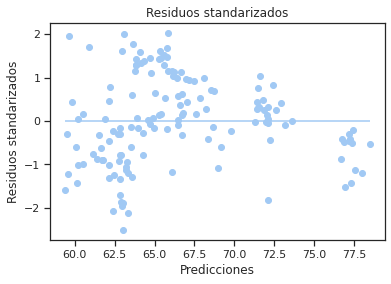

In [29]:
residuos_dev = residuos(['Latitude', 'Longitude', 'Continente_Nro'], df_developing)

In [30]:
df_developing = df_developing.assign(residuos_dev = residuos_dev)

In [31]:
df_developing = df_developing[(df_developing["residuos_dev"]**2)**0.5 <= 2]

### Luego Distancia de Cook

In [32]:
cook_dev, p_dev = cooksDist(['Latitude', 'Longitude', 'Continente_Nro'], df_developing)

VIF for Latitude 1.6073717205090376
VIF for Longitude 1.0949978540637906
VIF for Continente_Nro 1.4918223694096124


In [33]:
df_developing = df_developing.assign(cook_dev = cook_dev)

In [34]:
df_developing = df_developing[df_developing["cook_dev"] < 0.1]

### Y por último, el Leverage

In [35]:
leverage_dev = getLeverage(['Latitude', 'Longitude', 'Continente_Nro'], df_developing)

VIF for Latitude 1.6073717205090376
VIF for Longitude 1.0949978540637906
VIF for Continente_Nro 1.4918223694096124


In [36]:
df_developing = df_developing.assign(leverage_dev = leverage_dev)

In [37]:
df_developing = df_developing[df_developing["leverage_dev"] < 0.06]

### Vuelvo a hacer el análisis

VIF for Latitude 2.38301888353883
VIF for Longitude 1.34499464518738
VIF for Continente_Nro 2.134189822979081
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     25.73
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           4.52e-13
Time:                        23:18:14   Log-Likelihood:                -427.80
No. Observations:                 131   AIC:                             863.6
Df Residuals:                     127   BIC:                             875.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

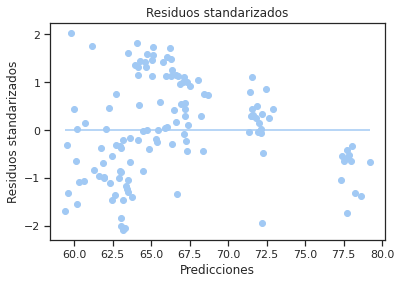

<Figure size 2160x2160 with 0 Axes>

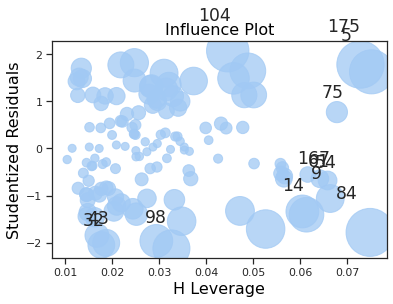

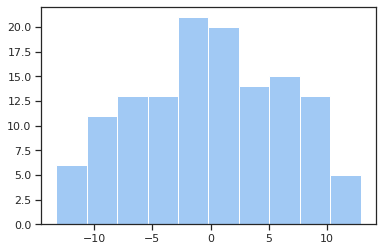

{'r2': 0.3780314615283352,
 'rmse': 6.339085871692754,
 'adjusted': 0.3633392913282172}

In [38]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro'], df_developing)

### Como siempre, con la quita de outliers mejora el ajuste, pero no es un valor convincente.